In [1]:
"""
XAS Spectra PCA + Clustering Pipeline
======================================
Reads pre-normalized XANES/EXAFS spectra, performs PCA to identify
the number of distinct spectral components, then clusters spectra
in PC-score space to group similar grains.

Assumes spectra are already normalized/flattened (e.g., via Athena or Larch).
Uses the flattened (post-edge-corrected) XANES by default to avoid
post-edge slope artifacts in PCA.

Requirements:
    pip install xraylarch scikit-learn scipy matplotlib numpy pandas

Usage:
    1. Update the CONFIGURATION section below with your paths and parameters.
    2. Run: python xas_pca_clustering.py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# Larch imports
from larch import Group
from larch.math import pca_train

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Directory containing your normalized spectra files
SPECTRA_DIR = Path("./flattened-spectra")

# Energy range to use for PCA (eV, relative to E0 or absolute)
# Set to None to use the full overlapping range
E_MIN = 7100  # e.g., -20 (relative to E0) or 7100 (absolute)
E_MAX = 7180  # e.g., 80 (relative to E0) or 7200 (absolute)
ENERGY_IS_RELATIVE = False  # True if E_MIN/E_MAX are relative to E0

# PCA region: 'xanes' uses normalized mu(E), 'exafs' uses chi(k)
PCA_REGION = "xanes"

# Common energy/k grid spacing for interpolation
E_STEP = 0.2  # eV step for XANES

# Max number of clusters to evaluate
MAX_CLUSTERS = 15

# Set to None to use silhouette-optimal k, or an integer to override
FORCE_K = 5

# Number of PCA components to use for clustering and target transformation.
# Set to None to use the IND minimum (automatic), or override with an integer
# if IND gives an unreasonable result (common with noisy microprobe data).
N_COMPONENTS = 5

# Reference spectra for target transformation (optional)
# List of file paths to reference spectra
REFERENCE_DIR = Path("./FeK-standards/fluorescence/flattened")
REFERENCE_FILES = ["2L-Fhy on sand.csv",
                    "2L-Fhy.csv",
                    "6L-Fhy.csv",
                    "Augite.csv",
                    "Biotite.csv",
                    "FeS.csv",
                    "Ferrosmectite.csv",
                    "Goethite on sand.csv",
                    "Goethite.csv",
                    "Green Rust - Carbonate.csv",
                    "Green Rust - Chloride.csv",
                    "Green Rust - Sulfate.csv",
                    "Hematite on sand.csv",
                    "Hematite.csv",
                    "Hornblende.csv",
                    "Ilmenite.csv",
                    "Jarosite.csv",
                    "Lepidocrocite.csv",
                    "Mackinawite (aged).csv",
                    "Mackinawite.csv",
                    "Maghemite.csv",
                    "Nontronite.csv",
                    "Pyrite.csv",
                    "Pyrrhotite.csv",
                    "Schwertmannite.csv",
                    "Siderite-n.csv",
                    "Siderite-s.csv",
                    "Vivianite.csv"] 
                    
REFERENCE_PATHS = [REFERENCE_DIR / f for f in REFERENCE_FILES]
# Output directory

# Bulk directory
BULK_DIR = Path("./bulk")
BULK_PATTERN = '*.csv'

OUTPUT_DIR = Path("./pca_results")

In [3]:
def load_ascii_spectra(spectra_dir, pattern="*.csv"):
    """
    Load pre-normalized/flattened spectra from individual CSV files.
    Expected format: comment lines starting with #, then two columns
    (energy, flat) comma-separated.
    """
    groups = []
    files = sorted(Path(spectra_dir).glob(pattern))
    for f in files:
        try:
            data = np.loadtxt(str(f), delimiter=",", comments="#")
            g = Group(
                energy=data[:, 0],
                flat=data[:, 1],
                filename=f.stem,
                _name=f.stem,
            )
            groups.append(g)
        except Exception as e:
            print(f"  Skipping {f.name}: {e}")
    print(f"Loaded {len(groups)} spectra from {spectra_dir}")
    return groups

In [4]:
def build_xanes_matrix(groups, e_min=None, e_max=None):
    """
    Interpolate normalized XANES spectra onto a common energy grid.
    Returns: energy_grid (1D), matrix (n_spectra x n_energy), names list
    """
    # Find the common energy range
    all_emin = max(g.energy.min() for g in groups)
    all_emax = min(g.energy.max() for g in groups)

    if e_min is not None:
        if ENERGY_IS_RELATIVE:
            # Use median E0 as reference
            e0_median = np.median([g.e0 for g in groups])
            all_emin = max(all_emin, e0_median + e_min)
        else:
            all_emin = max(all_emin, e_min)

    if e_max is not None:
        if ENERGY_IS_RELATIVE:
            e0_median = np.median([g.e0 for g in groups])
            all_emax = min(all_emax, e0_median + e_max)
        else:
            all_emax = min(all_emax, e_max)

    energy_grid = np.arange(all_emin, all_emax, E_STEP)
    matrix = np.zeros((len(groups), len(energy_grid)))
    names = []

    for i, g in enumerate(groups):
        matrix[i, :] = np.interp(energy_grid, g.energy, g.flat)
        names.append(g._name)

    print(f"Spectral matrix: {matrix.shape[0]} spectra × {matrix.shape[1]} energy points")
    print(f"Energy range: {energy_grid[0]:.1f} – {energy_grid[-1]:.1f} eV")
    return energy_grid, matrix, names

In [5]:
# ============================================================
# QUALITY SCREENING
# ============================================================

def screen_spectra(matrix, names, sigma_threshold=3.0):
    """
    Remove outlier spectra based on their distance from the mean spectrum.
    Returns filtered matrix and names.
    """
    mean_spec = matrix.mean(axis=0)
    distances = np.sqrt(np.sum((matrix - mean_spec) ** 2, axis=1))
    threshold = distances.mean() + sigma_threshold * distances.std()

    mask = distances < threshold
    n_removed = (~mask).sum()
    if n_removed > 0:
        print(f"Quality screen: removed {n_removed} spectra beyond {sigma_threshold}σ")
        removed_names = [names[i] for i in range(len(names)) if not mask[i]]
        for rn in removed_names:
            print(f"    Removed: {rn}")
    else:
        print("Quality screen: all spectra passed")

    filtered_names = [names[i] for i in range(len(names)) if mask[i]]
    return matrix[mask], filtered_names, mask

In [6]:
# ============================================================
# PCA
# ============================================================

def run_pca(x_grid, matrix, names):
    """
    Run PCA using Larch's pca_train.
    Returns the PCA result group.
    """
    # Build Larch groups for pca_train
    groups_for_pca = []
    for i in range(matrix.shape[0]):
        g = Group()
        if PCA_REGION == "xanes":
            g.energy = x_grid
            g.flat = matrix[i, :]
        else:
            g.k = x_grid
            g.chi = matrix[i, :] / (x_grid ** K_WEIGHT)  # undo k-weight
        g._name = names[i]
        groups_for_pca.append(g)

    if PCA_REGION == "xanes":
        pca_result = pca_train(groups_for_pca, arrayname="flat")
    else:
        pca_result = pca_train(groups_for_pca, arrayname="chi")

    return pca_result


def plot_pca_diagnostics(pca_result, output_dir):
    """Plot scree plot, IND, and component spectra."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    n_show = min(20, len(pca_result.variances))

    # --- Scree plot ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(range(1, n_show + 1), pca_result.variances[:n_show], "ko-")
    ax1.set_xlabel("Component number")
    ax1.set_ylabel("Eigenvalue (variance)")
    ax1.set_title("Scree Plot")
    ax1.set_xticks(range(1, n_show + 1))
    ax1.grid(True, alpha=0.3)

    # --- IND function ---
    ax2 = fig.add_subplot(gs[0, 1])
    ind = pca_result.ind
    ax2.semilogy(range(1, len(ind) + 1), ind, "rs-")
    ind_min = np.argmin(ind) + 1
    ax2.axvline(ind_min, color="blue", linestyle="--", label=f"IND min = {ind_min}")
    ax2.set_xlabel("Component number")
    ax2.set_ylabel("IND")
    ax2.set_title(f"Indicator Function (minimum at {ind_min} components)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- First few component spectra ---
    ax3 = fig.add_subplot(gs[1, 0])
    n_comp_show = min(5, ind_min + 2)
    for i in range(n_comp_show):
        offset = i * 0.5
        ax3.plot(pca_result.components[i] + offset, label=f"PC{i+1}")
    ax3.set_xlabel("Point index")
    ax3.set_ylabel("Component loading (offset)")
    ax3.set_title("Principal Component Spectra")
    ax3.legend(fontsize=8)

    # --- Cumulative variance ---
    ax4 = fig.add_subplot(gs[1, 1])
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances) * 100
    ax4.plot(range(1, n_show + 1), cumvar[:n_show], "go-")
    ax4.axhline(95, color="red", linestyle="--", alpha=0.5, label="95%")
    ax4.axhline(99, color="red", linestyle=":", alpha=0.5, label="99%")
    ax4.set_xlabel("Number of components")
    ax4.set_ylabel("Cumulative variance (%)")
    ax4.set_title("Cumulative Variance Explained")
    ax4.legend()
    ax4.set_xticks(range(1, n_show + 1))
    ax4.grid(True, alpha=0.3)

    plt.savefig(output_dir / "pca_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: pca_diagnostics.png")
    return ind_min

In [7]:
# ============================================================
# CLUSTERING
# ============================================================

def evaluate_kmeans(scores, max_k):
    """Evaluate k-means for different numbers of clusters."""
    results = {"k": [], "inertia": [], "silhouette": []}
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(scores)
        results["k"].append(k)
        results["inertia"].append(km.inertia_)
        results["silhouette"].append(silhouette_score(scores, labels))
    return results


def run_clustering(scores, names, n_components, output_dir):
    """
    Run k-means and hierarchical clustering on PCA scores.
    Produces diagnostic plots and returns cluster assignments.
    """
    max_k = min(MAX_CLUSTERS, len(names) - 1)

    # --- Evaluate k-means ---
    km_results = evaluate_kmeans(scores, max_k)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(km_results["k"], km_results["inertia"], "ko-")
    axes[0].set_xlabel("Number of clusters (k)")
    axes[0].set_ylabel("Inertia (within-cluster SS)")
    axes[0].set_title("K-Means Elbow Plot")
    axes[0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[1].plot(km_results["k"], km_results["silhouette"], "bs-")
    best_k = km_results["k"][np.argmax(km_results["silhouette"])]
    axes[1].axvline(best_k, color="red", linestyle="--",
                    label=f"Best k = {best_k}")
    axes[1].set_xlabel("Number of clusters (k)")
    axes[1].set_ylabel("Silhouette score")
    axes[1].set_title("Silhouette Analysis")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_dir / "kmeans_evaluation.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: kmeans_evaluation.png")
    print(f"Optimal k by silhouette: {best_k}")

    # --- Hierarchical clustering dendrogram ---
    linkage_matrix = linkage(pdist(scores, metric="euclidean"), method="ward")

    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=names,
        leaf_rotation=90,
        leaf_font_size=6,
        ax=ax,
    )
    ax.set_title("Hierarchical Clustering Dendrogram (Ward linkage)")
    ax.set_ylabel("Distance")
    plt.tight_layout()
    plt.savefig(output_dir / "dendrogram.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: dendrogram.png")

    # --- Score scatter plots with cluster assignments ---
    km_best = KMeans(n_clusters=best_k, n_init=20, random_state=42)
    labels = km_best.fit_predict(scores)

    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]

    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[-1], label="Cluster")
    plt.tight_layout()
    plt.savefig(output_dir / "score_scatter.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: score_scatter.png")

    return labels, best_k, km_best

In [8]:
# ============================================================
# CLUSTER INSPECTION
# ============================================================

def plot_cluster_spectra(x_grid, matrix, names, labels, n_clusters, output_dir):
    """Plot all spectra in each cluster, plus cluster centroids."""
    xlabel = "Energy (eV)" if PCA_REGION == "xanes" else f"k (Å⁻¹)"

    # Individual cluster plots
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5),
                             sharey=True)
    if n_clusters == 1:
        axes = [axes]

    centroids = []
    for ci in range(n_clusters):
        mask = labels == ci
        cluster_spectra = matrix[mask]
        centroid = cluster_spectra.mean(axis=0)
        centroids.append(centroid)
        cluster_names = [names[i] for i in range(len(names)) if mask[i]]

        ax = axes[ci]
        for spec in cluster_spectra:
            ax.plot(x_grid, spec, alpha=0.3, color=f"C{ci}")
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.set_xlabel(xlabel)
        ax.set_title(f"Cluster {ci+1} (n={mask.sum()})")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_spectra.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_spectra.png")

    # Overlay of all centroids
    fig, ax = plt.subplots(figsize=(8, 6))
    for ci, centroid in enumerate(centroids):
        ax.plot(x_grid, centroid, label=f"Cluster {ci+1}", linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    ax.set_title("Cluster Centroids Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_centroids.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_centroids.png")

    return np.array(centroids)

In [9]:
# ============================================================
# OUTLIER / RARE PHASE DETECTION
# ============================================================

def find_outliers(scores, names, labels, n_sigma=2.5):
    """
    Identify spectra that are far from their cluster centroid.
    These may represent rare phases or mixed grains.
    """
    outliers = []
    for ci in np.unique(labels):
        mask = labels == ci
        cluster_scores = scores[mask]
        centroid = cluster_scores.mean(axis=0)
        distances = np.sqrt(np.sum((cluster_scores - centroid) ** 2, axis=1))
        threshold = distances.mean() + n_sigma * distances.std()

        cluster_names = [names[i] for i in range(len(names)) if mask[i]]
        for idx, (d, name) in enumerate(zip(distances, cluster_names)):
            if d > threshold:
                outliers.append({
                    "name": name,
                    "cluster": ci,
                    "distance": d,
                    "threshold": threshold,
                })

    if outliers:
        print(f"\nPotential outliers / rare phases ({len(outliers)} spectra):")
        for o in outliers:
            print(f"  {o['name']} (cluster {o['cluster']+1}, "
                  f"dist={o['distance']:.3f}, threshold={o['threshold']:.3f})")
    else:
        print("\nNo outliers detected at the current threshold.")

    return outliers

In [10]:
# ============================================================
# TARGET TRANSFORMATION (optional)
# ============================================================

def run_target_transform(pca_result, reference_files, n_components):
    """
    Test reference spectra against PCA model by manual projection.
    Interpolates each reference onto the PCA energy grid, projects onto
    the first n components, reconstructs, and computes residual.
    """
    if not reference_files:
        print("\nNo reference files provided — skipping target transformation.")
        return None

    energy_grid = pca_result.x
    components = pca_result.components[:n_components]
    mean_spec = pca_result.mean

    print(f"\nTarget transformation results (using {n_components} components):")
    print(f"{'Reference':<30s} {'Chi-square':>12s} {'R-factor':>10s}")
    print("-" * 54)

    results = []
    for ref_path in reference_files:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_energy = ref_dat[:, 0]
            ref_flat = ref_dat[:, 1]

            # Interpolate reference onto PCA energy grid
            ref_interp = np.interp(energy_grid, ref_energy, ref_flat)

            # Mean-center and project onto components
            centered = ref_interp - mean_spec
            weights = centered @ components.T
            reconstructed = weights @ components + mean_spec

            # Compute fit quality
            residual = ref_interp - reconstructed
            chi_sq = np.sum(residual ** 2) / len(residual)
            r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(ref_interp))

            print(f"{Path(ref_path).stem:<30s} {chi_sq:>12.6f} {r_factor:>10.4f}")
            results.append({
                "reference": Path(ref_path).stem,
                "chi_square": chi_sq,
                "r_factor": r_factor,
            })
        except Exception as e:
            print(f"{Path(ref_path).stem:<30s} FAILED: {e}")

    # Sort by chi-square
    if results:
        results.sort(key=lambda x: x["chi_square"])
        print(f"\nRanked by fit quality (best first):")
        for i, r in enumerate(results, 1):
            print(f"  {i:2d}. {r['reference']:<30s} χ²={r['chi_square']:.6f}  R={r['r_factor']:.4f}")

    print("\nInterpretation:")
    print("  Lower chi-square / R-factor = better reconstruction from PCA components.")
    print("  Well-reconstructed references are consistent with species in the dataset.")
    print("  Poor reconstruction suggests that species is not represented.")

    return results

In [11]:
# ============================================================
# EXPORT RESULTS
# ============================================================

def export_results(names, labels, scores, n_components, outliers, output_dir):
    """Save cluster assignments and scores to CSV."""
    df = pd.DataFrame({
        "spectrum": names,
        "cluster": labels + 1,  # 1-indexed for readability
    })
    for i in range(n_components):
        df[f"PC{i+1}_score"] = scores[:, i]

    df["is_outlier"] = df["spectrum"].isin([o["name"] for o in outliers])

    outpath = output_dir / "cluster_assignments.csv"
    df.to_csv(outpath, index=False)
    print(f"\nSaved: {outpath}")
    return df

In [12]:
# ============================================================
# HELPER FUNCTIONS FOR INTERACTIVE EXPLORATION
# ============================================================

def override_clusters(scores, k):
    """Re-cluster with a specific k."""
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(scores)
    print(f"Clustered into k={k}:")
    for i in range(k):
        print(f"  Cluster {i+1}: {(labels==i).sum()} spectra")
    return labels, k

def plot_score_scatter(scores, labels, n_components, best_k, output_dir=None, suffix=""):
    """Score scatter plots colored by cluster labels."""
    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]
    
    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes[-1], label="Cluster", ticks=range(best_k))
    plt.tight_layout()
    if output_dir:
        plt.savefig(output_dir / f"score_scatter{suffix}.png", dpi=150, bbox_inches="tight")
    plt.show()


In [13]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Step 1: Load data
groups = load_ascii_spectra(SPECTRA_DIR)
if len(groups) < 3:
    raise ValueError(f"Need at least 3 spectra for PCA, got {len(groups)}")


Loaded 172 spectra from flattened-spectra


In [14]:
# Step 2: Build spectral matrix
x_grid, matrix, names = build_xanes_matrix(groups, E_MIN, E_MAX)


Spectral matrix: 172 spectra × 400 energy points
Energy range: 7100.0 – 7179.8 eV


In [15]:
# Step 3: Quality screening
matrix, names, quality_mask = screen_spectra(matrix, names)


Quality screen: all spectra passed


In [16]:
# Step 4: PCA
pca_result = run_pca(x_grid, matrix, names)
ind_min = plot_pca_diagnostics(pca_result, OUTPUT_DIR)

# Determine number of components
if N_COMPONENTS is not None:
    n_components = N_COMPONENTS
    print(f"Using manual override: {n_components} components")
elif ind_min > len(names) // 2:
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances)
    n_components = int(np.argmax(cumvar >= 0.95)) + 1
    print(f"IND minimum unreliable ({ind_min}). Using 95% variance cutoff: {n_components} components")
else:
    n_components = ind_min
    print(f"Number of significant components (IND): {n_components}")

scores = (pca_result.ydat - pca_result.mean) @ pca_result.components[:n_components].T


Saved: pca_diagnostics.png
Using manual override: 5 components


In [17]:
# Step 5: Target transformation
tt_results = run_target_transform(pca_result, REFERENCE_PATHS, n_components)



Target transformation results (using 5 components):
Reference                        Chi-square   R-factor
------------------------------------------------------
2L-Fhy on sand                     0.003484     0.0715
2L-Fhy                             0.002906     0.0662
6L-Fhy                             0.001864     0.0523
Augite                             0.000587     0.0245
Biotite                            0.001663     0.0358
FeS                                0.004224     0.0594
Ferrosmectite                      0.004359     0.0848
Goethite on sand                   0.006053     0.0964
Goethite                           0.002336     0.0553
Green Rust - Carbonate             0.001086     0.0310
Green Rust - Chloride              0.000571     0.0259
Green Rust - Sulfate               0.000521     0.0236
Hematite on sand                   0.004819     0.0818
Hematite                           0.001716     0.0465
Hornblende                         0.000718     0.0251
Ilmenite    

In [18]:
# Step 6a: Clustering evaluation (silhouette + dendrogram)
labels, best_k, km_model = run_clustering(scores, names, n_components, OUTPUT_DIR)


Saved: kmeans_evaluation.png
Optimal k by silhouette: 2
Saved: dendrogram.png
Saved: score_scatter.png


Clustered into k=5:
  Cluster 1: 51 spectra
  Cluster 2: 36 spectra
  Cluster 3: 26 spectra
  Cluster 4: 33 spectra
  Cluster 5: 26 spectra


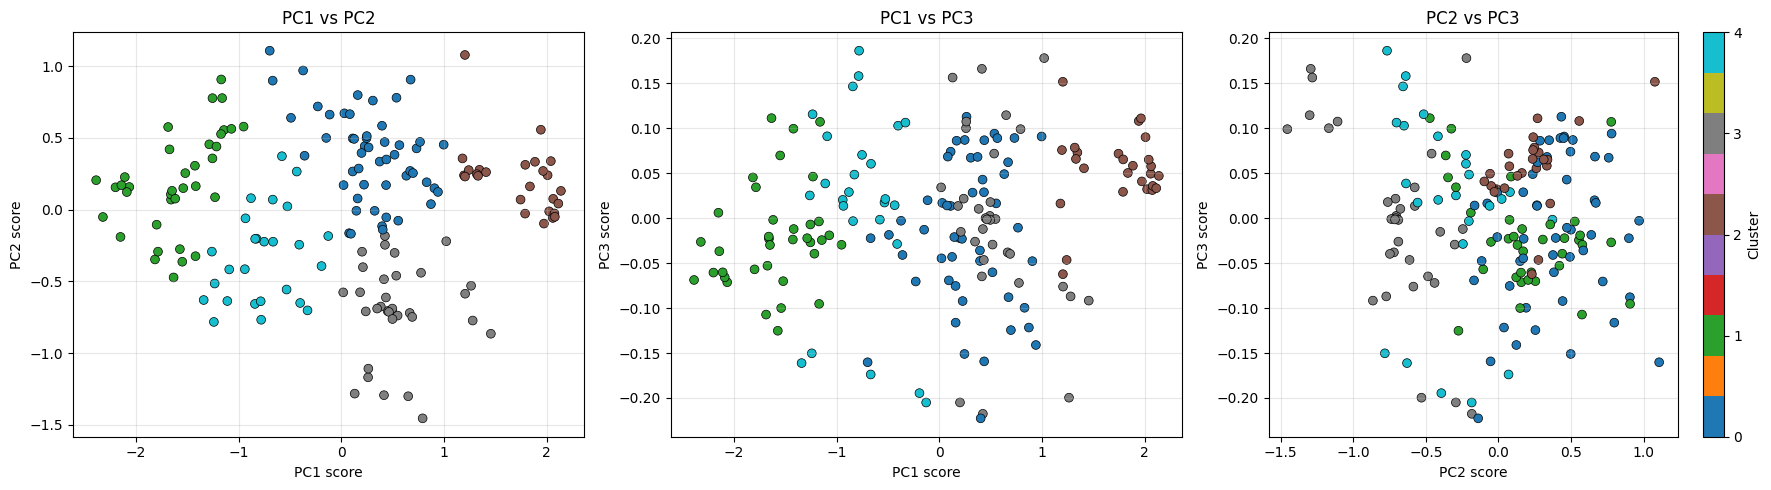

In [19]:
# Step 6b: Override cluster count and visualize
# Change k here and re-run this cell + cells below to explore different groupings
labels, best_k = override_clusters(scores, k=FORCE_K or best_k)
plot_score_scatter(scores, labels, n_components, best_k, OUTPUT_DIR, suffix=f"_k{best_k}")


In [20]:
# Step 7: Cluster inspection
centroids = plot_cluster_spectra(x_grid, matrix, names, labels, best_k, OUTPUT_DIR)


Saved: cluster_spectra.png
Saved: cluster_centroids.png



Cluster 1 centroid
Best fit (4 components, R=0.0059, χ²=0.000035):
  Biotite                        0.0764  (7.5%)
  Hornblende                     0.4571  (44.6%)
  Mackinawite (aged)             0.2907  (28.3%)
  Vivianite                      0.2015  (19.6%)
  Sum                            1.0257

Cluster 2 centroid
Best fit (4 components, R=0.0061, χ²=0.000029):
  6L-Fhy                         0.4525  (44.5%)
  Augite                         0.2152  (21.2%)
  Biotite                        0.1275  (12.5%)
  Ferrosmectite                  0.2222  (21.8%)
  Sum                            1.0174

Cluster 3 centroid
Best fit (4 components, R=0.0177, χ²=0.000392):
  Biotite                        0.5044  (49.7%)
  Mackinawite                    0.2218  (21.8%)
  Pyrrhotite                     0.1112  (11.0%)
  Siderite-n                     0.1778  (17.5%)
  Sum                            1.0153

Cluster 4 centroid
Best fit (4 components, R=0.0129, χ²=0.000206):
  Biotite            

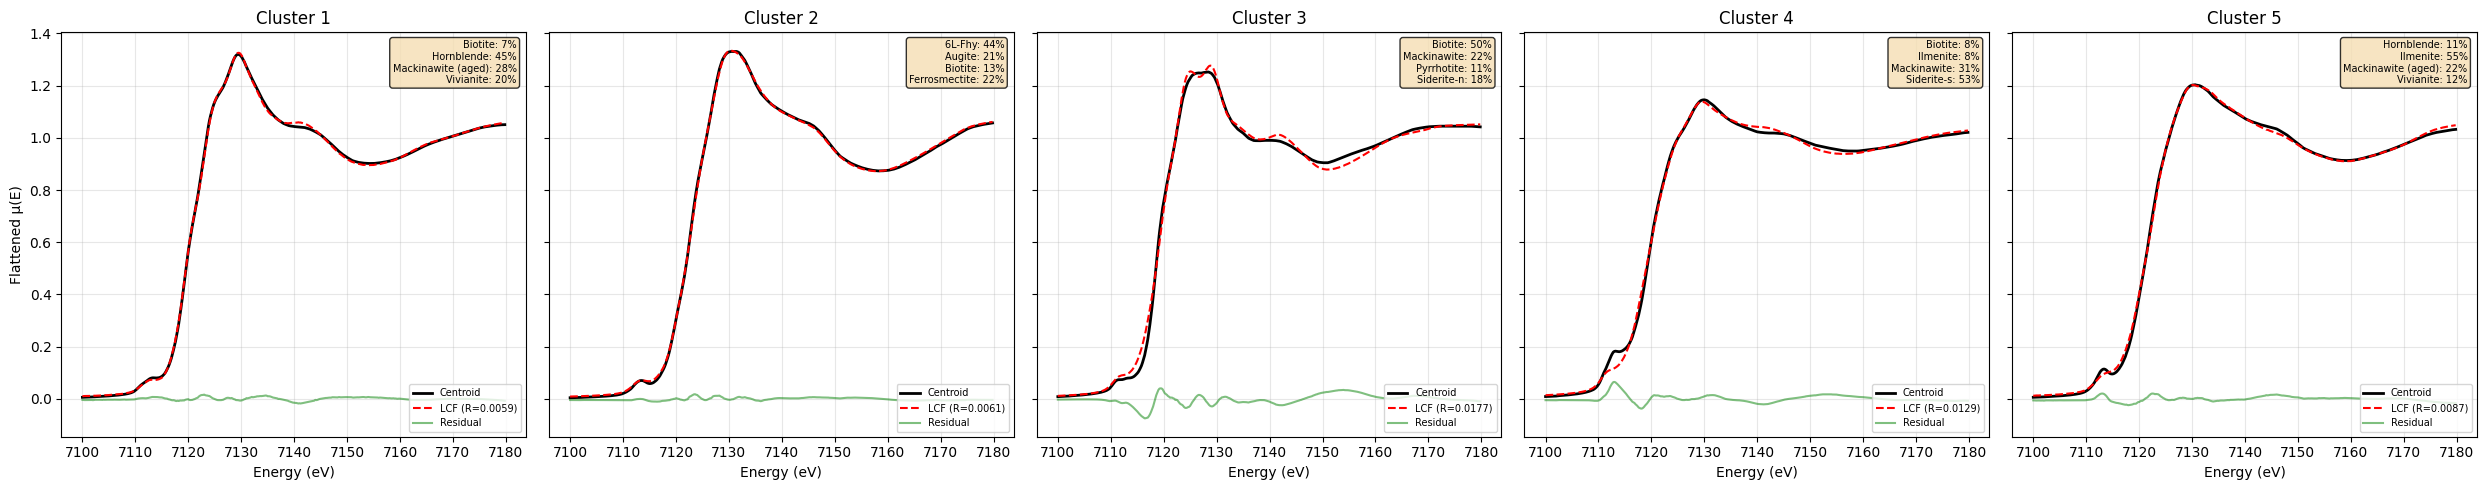

In [21]:
# LCF of cluster centroids against reference library
from itertools import combinations

def lcf_centroids(x_grid, centroids, reference_paths, max_refs=4, e_min=None, e_max=None):
    """
    Linear combination fitting of each cluster centroid against reference spectra.
    Tests all combinations of 1 to max_refs references and picks the best fit.
    """
    # Load and interpolate references
    refs = {}
    for ref_path in reference_paths:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_interp = np.interp(x_grid, ref_dat[:, 0], ref_dat[:, 1])
            refs[Path(ref_path).stem] = ref_interp
        except Exception as e:
            print(f"  Skipping {Path(ref_path).stem}: {e}")

    ref_names = list(refs.keys())
    ref_matrix = np.array([refs[n] for n in ref_names])

    # Optional energy mask
    if e_min is not None or e_max is not None:
        mask = np.ones(len(x_grid), dtype=bool)
        if e_min is not None:
            mask &= x_grid >= e_min
        if e_max is not None:
            mask &= x_grid <= e_max
    else:
        mask = np.ones(len(x_grid), dtype=bool)

    all_results = []

    for ci, centroid in enumerate(centroids):
        print(f"\n{'='*60}")
        print(f"Cluster {ci+1} centroid")
        print(f"{'='*60}")

        best_fit = {"r_factor": np.inf}

        # Try combinations of 1 to max_refs references
        for n_ref in range(1, max_refs + 1):
            for combo in combinations(range(len(ref_names)), n_ref):
                combo_names = [ref_names[i] for i in combo]
                A = ref_matrix[list(combo)][:, mask].T
                b = centroid[mask]

                # Non-negative least squares
                from scipy.optimize import nnls
                weights, rnorm = nnls(A, b)

                # Compute fit quality
                fitted = A @ weights
                residual = b - fitted
                r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(b))
                chi_sq = np.sum(residual ** 2) / len(residual)
                weight_sum = np.sum(weights)

                if r_factor < best_fit["r_factor"]:
                    best_fit = {
                        "refs": combo_names,
                        "weights": weights,
                        "weight_sum": weight_sum,
                        "r_factor": r_factor,
                        "chi_sq": chi_sq,
                        "fitted": np.zeros_like(centroid),
                        "n_refs": n_ref,
                    }
                    best_fit["fitted"][mask] = fitted

        # Print best fit
        print(f"Best fit ({best_fit['n_refs']} components, R={best_fit['r_factor']:.4f}, "
              f"χ²={best_fit['chi_sq']:.6f}):")
        for name, w in zip(best_fit["refs"], best_fit["weights"]):
            pct = w / best_fit["weight_sum"] * 100 if best_fit["weight_sum"] > 0 else 0
            print(f"  {name:<30s} {w:.4f}  ({pct:.1f}%)")
        print(f"  {'Sum':<30s} {best_fit['weight_sum']:.4f}")

        best_fit["cluster"] = ci + 1
        all_results.append(best_fit)

    # Plot fits
    n_clusters = len(centroids)
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)
    if n_clusters == 1:
        axes = [axes]

    for ci, (centroid, result) in enumerate(zip(centroids, all_results)):
        ax = axes[ci]
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.plot(x_grid, result["fitted"], "r--", linewidth=1.5, label=f"LCF (R={result['r_factor']:.4f})")
        ax.plot(x_grid, centroid - result["fitted"], "g-", alpha=0.5, label="Residual")

        # Build legend with components
        legend_text = "\n".join(
            f"{n}: {w/result['weight_sum']*100:.0f}%"
            for n, w in zip(result["refs"], result["weights"])
        )
        ax.text(0.98, 0.98, legend_text, transform=ax.transAxes,
                fontsize=7, verticalalignment="top", horizontalalignment="right",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

        ax.set_xlabel("Energy (eV)")
        ax.set_title(f"Cluster {ci+1}")
        ax.legend(fontsize=7, loc="lower right")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "lcf_centroids.png", dpi=150, bbox_inches="tight")
    plt.show()

    return all_results

lcf_results = lcf_centroids(x_grid, centroids, REFERENCE_PATHS, max_refs=4)

In [22]:
# LCF of individual spectra against reference library
    
def lcf_individual_spectra(x_grid, matrix, names, labels, reference_paths, 
                           max_refs=3, e_min=None, e_max=None):
    """
    Linear combination fitting of each individual spectrum against reference spectra.
    Returns a DataFrame with fit results for every spectrum.
    """
    from scipy.optimize import nnls
    from itertools import combinations

    # Load and interpolate references
    refs = {}
    for ref_path in reference_paths:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_interp = np.interp(x_grid, ref_dat[:, 0], ref_dat[:, 1])
            refs[Path(ref_path).stem] = ref_interp
        except Exception as e:
            print(f"  Skipping {Path(ref_path).stem}: {e}")

    ref_names = list(refs.keys())
    ref_matrix = np.array([refs[n] for n in ref_names])

    # Energy mask
    mask = np.ones(len(x_grid), dtype=bool)
    if e_min is not None:
        mask &= x_grid >= e_min
    if e_max is not None:
        mask &= x_grid <= e_max

    # Precompute all reference combinations
    all_combos = []
    for n_ref in range(1, max_refs + 1):
        for combo in combinations(range(len(ref_names)), n_ref):
            all_combos.append(combo)
    print(f"Testing {len(all_combos)} reference combinations per spectrum "
          f"({len(matrix)} spectra = {len(all_combos) * len(matrix):,} total fits)")

    # Fit each spectrum
    results = []
    for si in range(len(matrix)):
        spectrum = matrix[si]
        b = spectrum[mask]
        best = {"r_factor": np.inf}

        for combo in all_combos:
            A = ref_matrix[list(combo)][:, mask].T
            weights, _ = nnls(A, b)
            fitted = A @ weights
            residual = b - fitted
            r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(b))

            if r_factor < best["r_factor"]:
                best = {
                    "refs": [ref_names[i] for i in combo],
                    "weights": weights,
                    "r_factor": r_factor,
                    "chi_sq": np.sum(residual ** 2) / len(residual),
                    "weight_sum": np.sum(weights),
                }

        # Build result row
        row = {
            "spectrum": names[si],
            "cluster": labels[si] + 1,
            "r_factor": best["r_factor"],
            "chi_sq": best["chi_sq"],
            "weight_sum": best["weight_sum"],
            "n_refs": len(best["refs"]),
        }
        for rn, w in zip(best["refs"], best["weights"]):
            row[rn] = w / best["weight_sum"] if best["weight_sum"] > 0 else 0
        results.append(row)

        if (si + 1) % 25 == 0 or si == len(matrix) - 1:
            print(f"  Fitted {si+1}/{len(matrix)} spectra")

    df = pd.DataFrame(results).fillna(0)

    # Sort reference columns by frequency of appearance
    ref_cols = [c for c in df.columns if c in ref_names]
    ref_cols_sorted = sorted(ref_cols, key=lambda c: (df[c] > 0).sum(), reverse=True)
    meta_cols = ["spectrum", "cluster", "r_factor", "chi_sq", "weight_sum", "n_refs"]
    df = df[meta_cols + ref_cols_sorted]

    # Print summary by cluster
    print(f"\n{'='*70}")
    print("SUMMARY: Average composition by cluster (normalized %)")
    print(f"{'='*70}")
    for ci in sorted(df["cluster"].unique()):
        cdf = df[df["cluster"] == ci]
        print(f"\nCluster {ci} (n={len(cdf)}, mean R={cdf['r_factor'].mean():.4f}):")
        for col in ref_cols_sorted:
            mean_pct = cdf[col].mean() * 100
            if mean_pct > 1:
                print(f"  {col:<30s} {mean_pct:5.1f}%")

    # Print poorly fit spectra
    poor_fits = df[df["r_factor"] > 0.05].sort_values("r_factor", ascending=False)
    if len(poor_fits) > 0:
        print(f"\n{'='*70}")
        print(f"POORLY FIT SPECTRA (R > 0.05): {len(poor_fits)} spectra")
        print(f"{'='*70}")
        for _, row in poor_fits.iterrows():
            print(f"  {row['spectrum']:<50s} R={row['r_factor']:.4f}  cluster={row['cluster']}")
    else:
        print(f"\nAll spectra fit with R < 0.05")

    # Save
    outpath = OUTPUT_DIR / "lcf_individual.csv"
    df.to_csv(outpath, index=False, float_format="%.4f")
    print(f"\nSaved: {outpath}")

    return df

lcf_df = lcf_individual_spectra(x_grid, matrix, names, labels, REFERENCE_PATHS, max_refs=3)

Testing 3682 reference combinations per spectrum (172 spectra = 633,304 total fits)
  Fitted 25/172 spectra
  Fitted 50/172 spectra
  Fitted 75/172 spectra
  Fitted 100/172 spectra
  Fitted 125/172 spectra
  Fitted 150/172 spectra
  Fitted 172/172 spectra

SUMMARY: Average composition by cluster (normalized %)

Cluster 1 (n=51, mean R=0.0136):
  Biotite                         19.0%
  Mackinawite (aged)              15.3%
  Hornblende                      20.5%
  Siderite-s                      10.4%
  Augite                          15.7%
  Vivianite                        6.0%
  Green Rust - Carbonate           4.4%
  Hematite                         1.1%
  2L-Fhy                           1.3%
  Pyrite                           1.3%

Cluster 2 (n=36, mean R=0.0113):
  Biotite                          4.0%
  Mackinawite (aged)               2.2%
  Hornblende                      19.4%
  Augite                          12.8%
  Vivianite                        1.1%
  6L-Fhy            

In [23]:
# Step 8: Outlier / rare phase detection
outliers = find_outliers(scores, names, labels)



Potential outliers / rare phases (3 spectra):
  FeXANES_GT5_flaky2_FeXRD_10.001 (cluster 1, dist=1.085, threshold=1.048)
  FeXANES_GT5_flakysmooth2_Fe_22.001 (cluster 1, dist=1.232, threshold=1.048)
  FeXANES_GT15_super_dark_Fe_14.001 (cluster 3, dist=1.020, threshold=0.824)


In [24]:
# Step 9: Export results
df = export_results(names, labels, scores, n_components, outliers, OUTPUT_DIR)

# Summary
print(f"\nTotal spectra analyzed: {len(names)}")
print(f"PCA components: {n_components}")
print(f"Clusters: {best_k}")
for ci in range(best_k):
    print(f"  Cluster {ci+1}: {(labels == ci).sum()} spectra")
print(f"Outliers: {len(outliers)}")



Saved: pca_results/cluster_assignments.csv

Total spectra analyzed: 172
PCA components: 5
Clusters: 5
  Cluster 1: 51 spectra
  Cluster 2: 36 spectra
  Cluster 3: 26 spectra
  Cluster 4: 33 spectra
  Cluster 5: 26 spectra
Outliers: 3


Using 10 references, testing 385 combinations per spectrum
Found 23 bulk spectra
  Skipping bulk_lcf_grouped.csv: could not parse depth
  Skipping bulk_lcf_mineral_refs.csv: could not parse depth
Fit 21 spectra across 3 stations

Saved: bulk/bulk_lcf_mineral_refs.csv


GP17_station15_19908:
   Depth       R   Sum  Components
  ----------------------------------------------------------------------
      1  0.0194  1.01  Hornblende 7%, Ferrosmectite 93%
      3  0.0179  1.01  Hornblende 6%, Ferrosmectite 94%
      5  0.0208  1.00  Hornblende 26%, Ferrosmectite 74%
      7  0.0227  1.01  Hornblende 26%, Ferrosmectite 74%
      9  0.0218  1.01  Hornblende 35%, Ferrosmectite 65%
     11  0.0196  1.01  Hornblende 28%, Ferrosmectite 72%
     15  0.0239  1.00  Hornblende 33%, Ferrosmectite 67%

GP17_station27_20892:
   Depth       R   Sum  Components
  ----------------------------------------------------------------------
      1  0.0157  1.01  Hornblende 13%, 6L-Fhy 4%, Ferrosmectite 83%
    

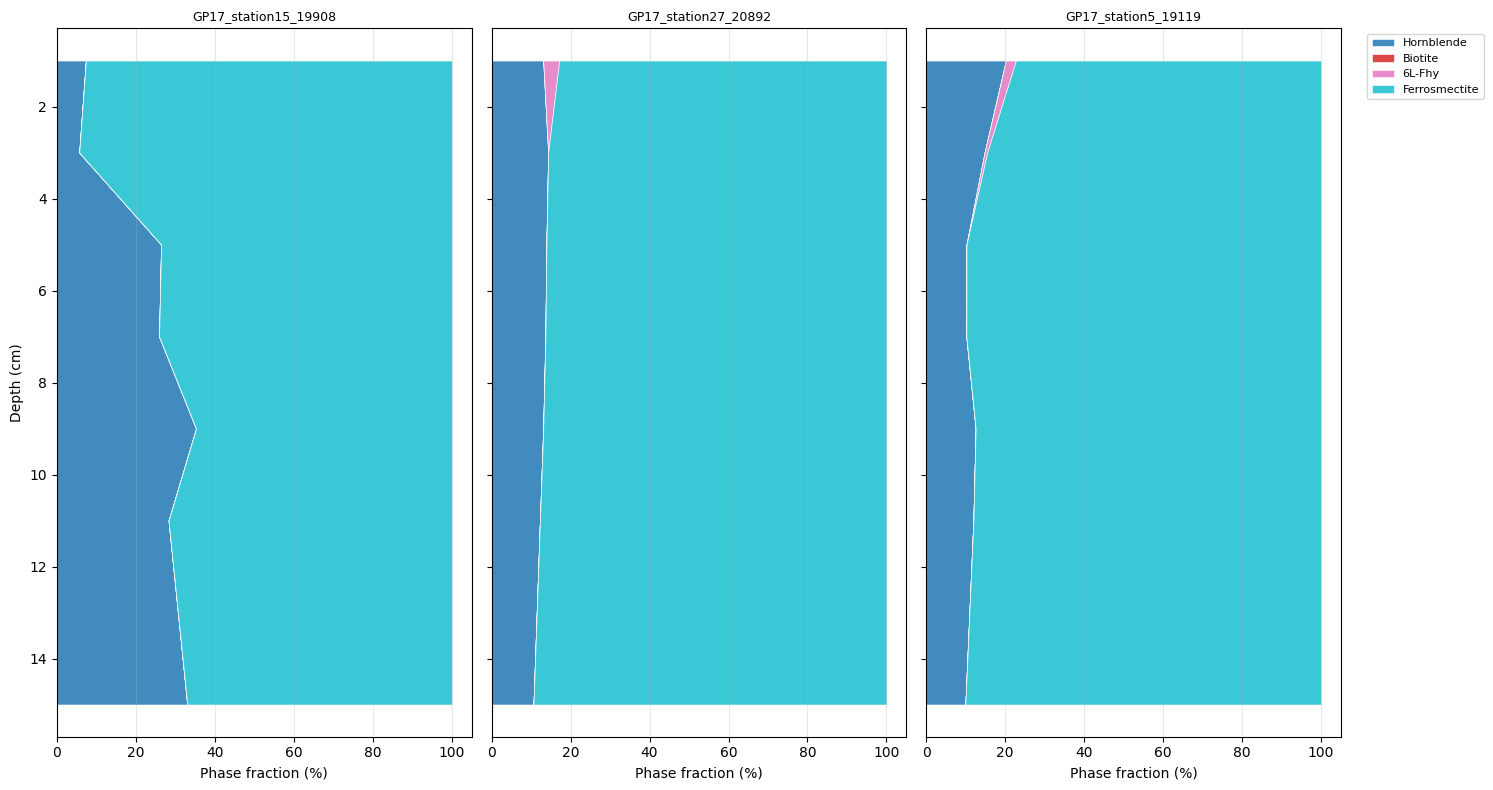

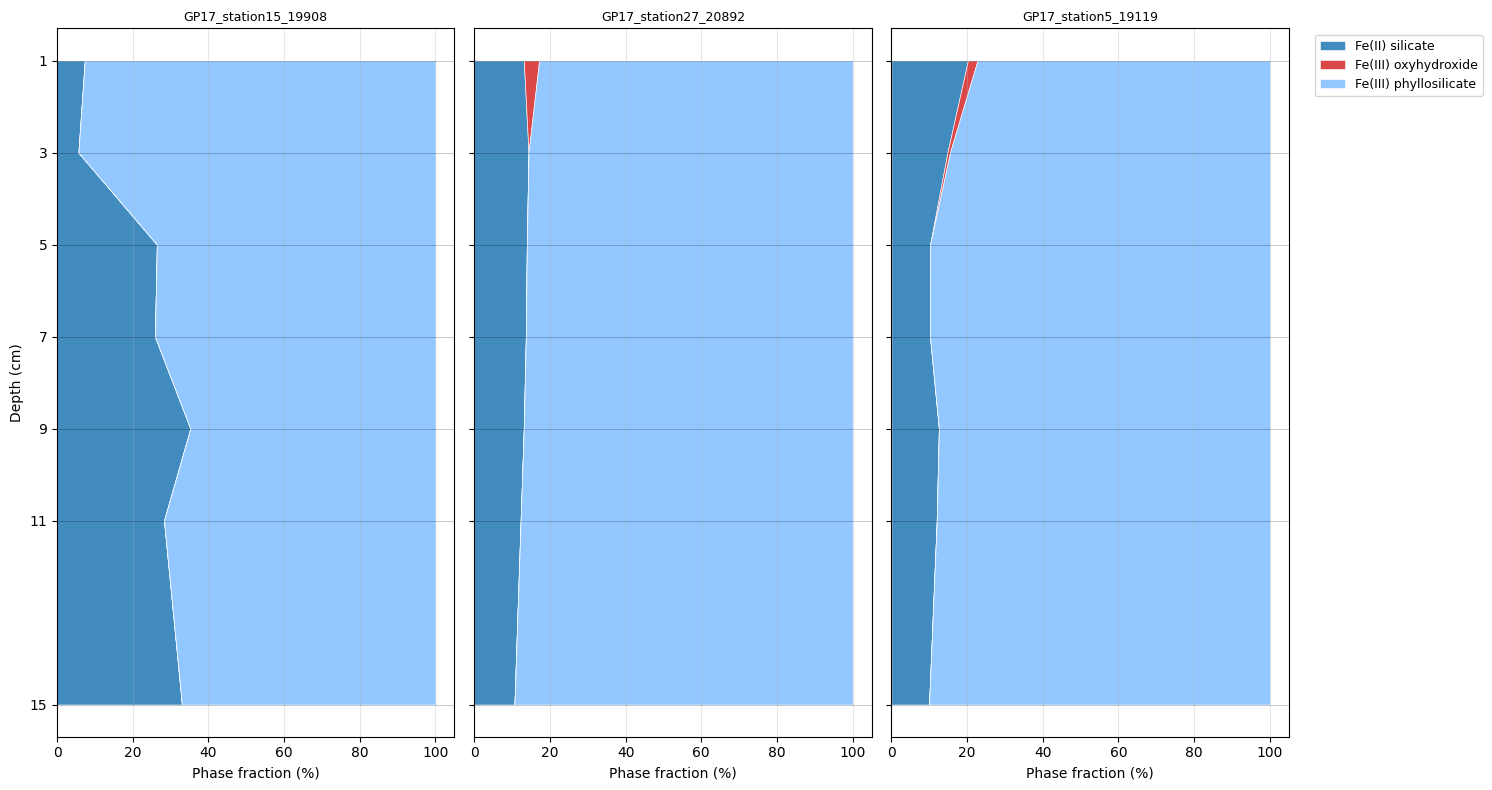

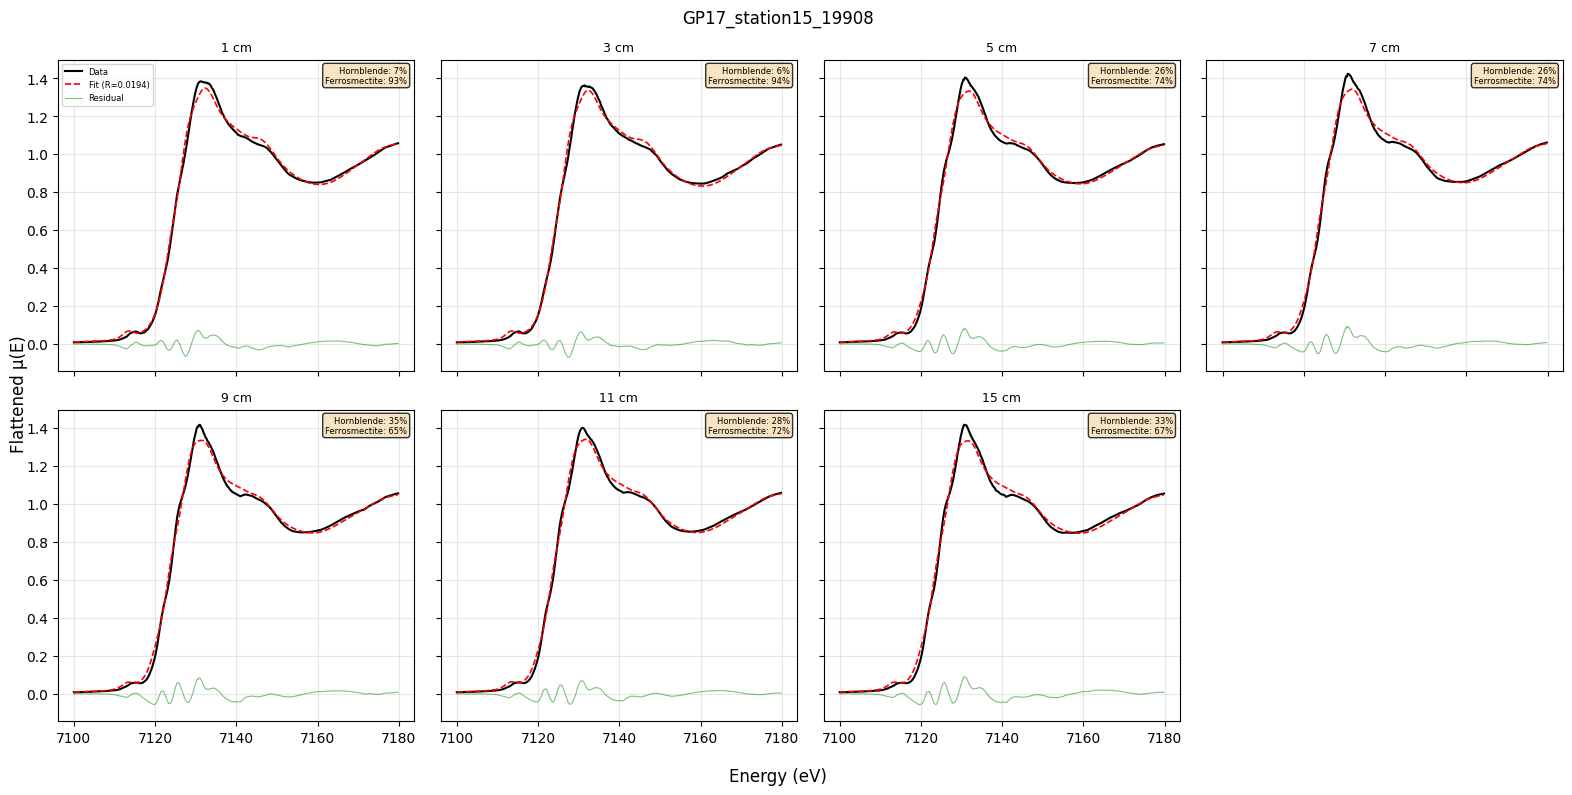

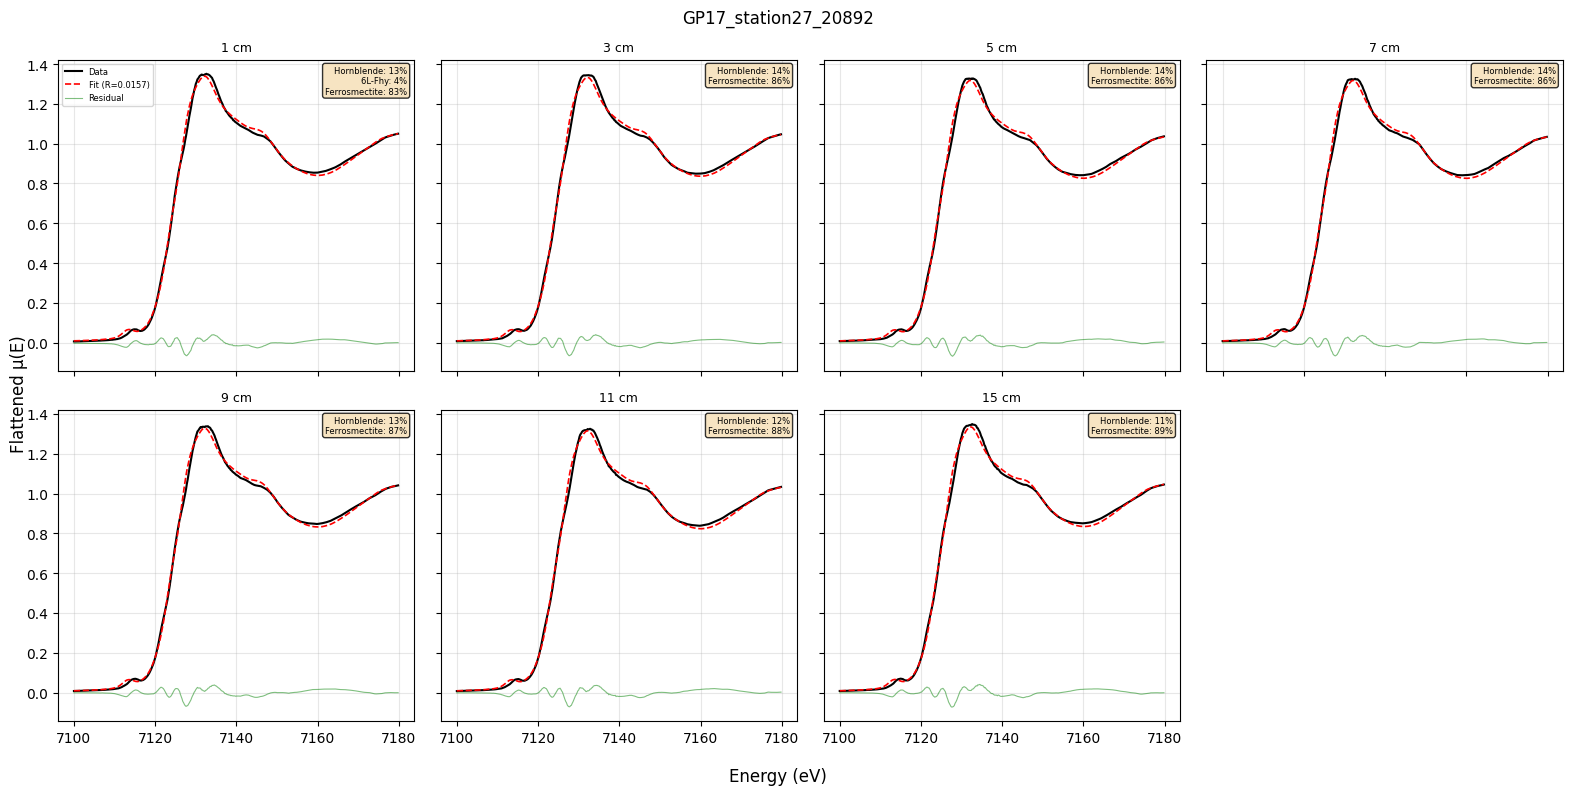

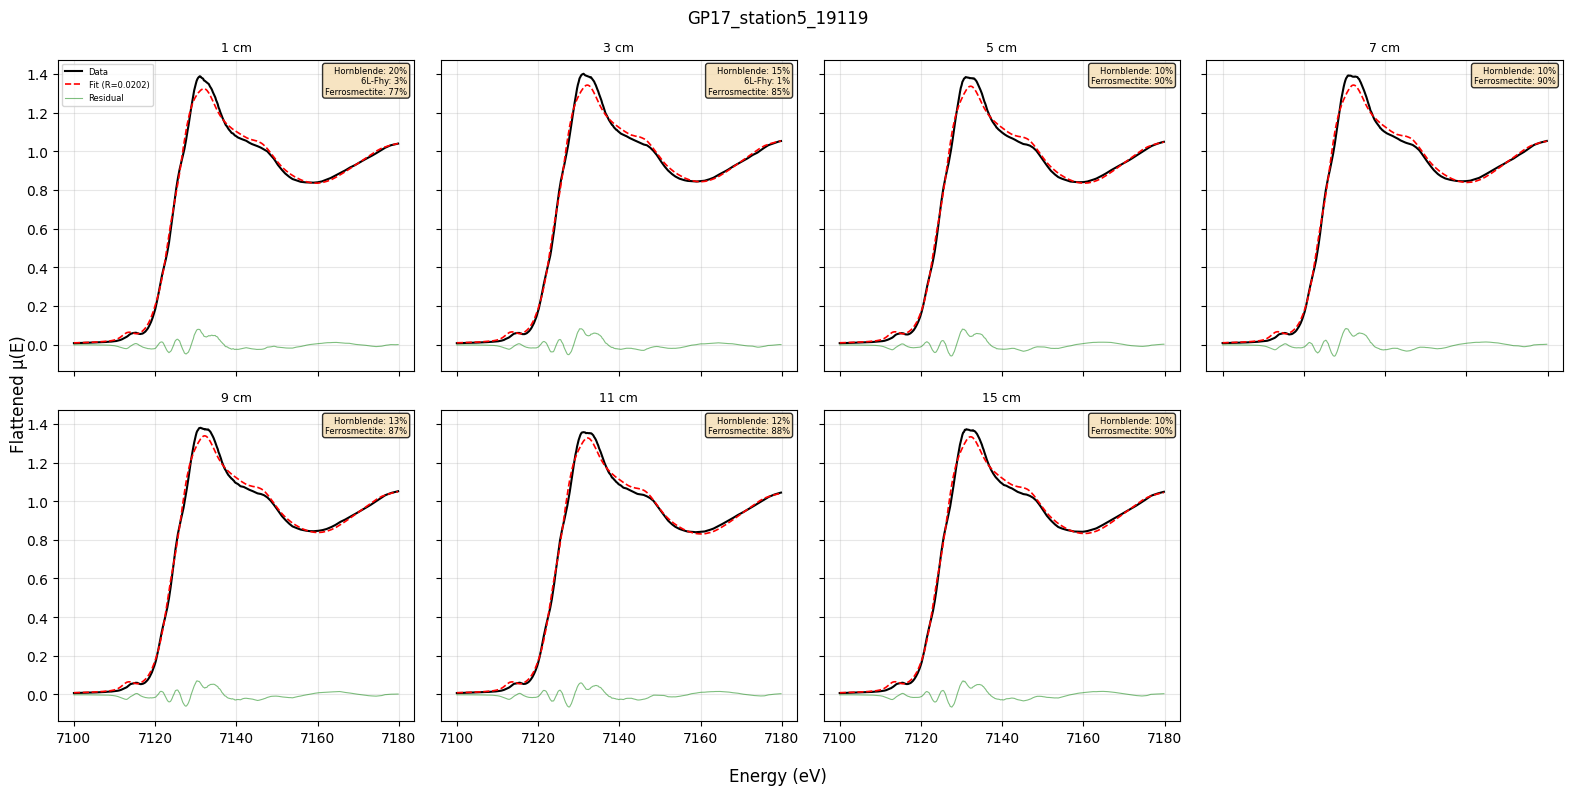

In [25]:
# LCF of bulk spectra using mineral references informed by PCA results
#
# The PCA/clustering identified these dominant phases:
#   - Hornblende, Augite, Biotite (silicates)
#   - 6L-Fhy, Ferrosmectite (Fe(III) phases)
#   - Mackinawite, Mackinawite (aged), Pyrrhotite (sulfides)
#   - Siderite-s, Siderite-n (carbonates)
#   - Ilmenite (heavy mineral)
#   - Vivianite (phosphate)
#
# Adjust this list based on your interpretation of the PCA results.

# ============================================================
# CONFIGURATION
# ============================================================

# References to use for bulk LCF — selected from PCA/clustering results
# Group by mineralogical class to avoid redundancy
BULK_REFS = {
    # name: path — pick one representative per spectral type
    "Hornblende":         REFERENCE_DIR / "Hornblende.csv",
    "Biotite":            REFERENCE_DIR / "Biotite.csv",
    "6L-Fhy":             REFERENCE_DIR / "6L-Fhy.csv",
    "Ferrosmectite":      REFERENCE_DIR / "Ferrosmectite.csv",
    "Goethite":           REFERENCE_DIR / "Goethite.csv",
    "Mackinawite (aged)": REFERENCE_DIR / "Mackinawite (aged).csv",
    "Siderite-s":         REFERENCE_DIR / "Siderite-s.csv",
    "Ilmenite":           REFERENCE_DIR / "Ilmenite.csv",
    "Pyrrhotite":         REFERENCE_DIR / "Pyrrhotite.csv",
    "Vivianite":          REFERENCE_DIR / "Vivianite.csv",
}

# Max number of references per fit
BULK_MAX_REFS = 4

BULK_OUTPUT_DIR = BULK_DIR

# Phase grouping for plotting
PHASE_GROUPS = {
    "Fe(III) oxyhydroxide":    ["6L-Fhy", "Goethite"],
    "Fe(III) phyllosilicate":  ["Ferrosmectite"],
    "Fe(II) phyllosilicate":   ["Biotite"],
    "Fe(II) silicate":         ["Hornblende"],
    "Fe sulfide":              ["Mackinawite (aged)", "Pyrrhotite"],
    "Fe(II) carbonate":        ["Siderite-s"],
    "Fe-Ti oxide":             ["Ilmenite"],
    "Fe(II) phosphate":        ["Vivianite"],
}

# Fixed plot order and colors
PLOT_ORDER = [
    "Fe(II) silicate",
   # "Fe(II) phyllosilicate",
    "Fe(III) oxyhydroxide",
    "Fe(III) phyllosilicate",
]

GROUP_COLORS = {
    "Fe(III) oxyhydroxide":    "#d62728",
    "Fe(III) phyllosilicate":  "#7fbfff",
    "Fe(II) phyllosilicate":   "#aec7e8",
    "Fe(II) silicate":         "#1f77b4",
    "Fe sulfide":              "#2ca02c",
    "Fe(II) carbonate":        "#ff7f0e",
    "Fe-Ti oxide":             "#9467bd",
    "Fe(II) phosphate":        "#8c564b",
}
# ============================================================
# FIT
# ============================================================

import re

def parse_bulk_filename(filename):
    """
    Extract station and depth from filename.
    Example: GP17_station5_19119_1cm_015_A_fl.avg -> station='GP17_station5_19119', depth=1.0
    """
    stem = Path(filename).stem
    depth_match = re.search(r'(\d+\.?\d*)cm', stem)
    if not depth_match:
        return None, None
    depth = float(depth_match.group(1))
    station = stem[:depth_match.start()].rstrip('_')
    return station, depth

    
def lcf_bulk_with_references(x_grid, bulk_dir, bulk_refs, max_refs=4, pattern="*.csv"):
    """
    Fit each bulk spectrum as a linear combination of mineral references.
    Tests all combinations of 1 to max_refs and picks the best fit.
    """
    from scipy.optimize import nnls
    from itertools import combinations

    # Load and interpolate references
    ref_names = list(bulk_refs.keys())
    ref_spectra = {}
    for name, path in bulk_refs.items():
        try:
            dat = np.loadtxt(str(path), delimiter=",", comments="#")
            ref_spectra[name] = np.interp(x_grid, dat[:, 0], dat[:, 1])
        except Exception as e:
            print(f"  Skipping {name}: {e}")
    
    ref_names = list(ref_spectra.keys())
    ref_matrix = np.array([ref_spectra[n] for n in ref_names])
    
    # Precompute combos
    all_combos = []
    for n in range(1, max_refs + 1):
        for combo in combinations(range(len(ref_names)), n):
            all_combos.append(combo)
    print(f"Using {len(ref_names)} references, testing {len(all_combos)} combinations per spectrum")

    # Load and fit bulk spectra
    bulk_files = sorted(Path(bulk_dir).glob(pattern))
    print(f"Found {len(bulk_files)} bulk spectra")

    results = []
    for bf in bulk_files:
        station, depth = parse_bulk_filename(bf.name)
        if station is None:
            print(f"  Skipping {bf.name}: could not parse depth")
            continue

        try:
            dat = np.loadtxt(str(bf), delimiter=",", comments="#")
            bulk_interp = np.interp(x_grid, dat[:, 0], dat[:, 1])

            best = {"r_factor": np.inf}
            for combo in all_combos:
                A = ref_matrix[list(combo)].T
                weights, _ = nnls(A, bulk_interp)
                fitted = A @ weights
                residual = bulk_interp - fitted
                r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(bulk_interp))

                if r_factor < best["r_factor"]:
                    best = {
                        "refs": [ref_names[i] for i in combo],
                        "weights": weights,
                        "r_factor": r_factor,
                        "chi_sq": np.sum(residual ** 2) / len(residual),
                        "weight_sum": np.sum(weights),
                        "fitted": fitted,
                    }

            row = {
                "filename": bf.name,
                "station": station,
                "depth_cm": depth,
                "r_factor": best["r_factor"],
                "chi_sq": best["chi_sq"],
                "weight_sum": best["weight_sum"],
                "n_refs": len(best["refs"]),
                "components": ", ".join(best["refs"]),
            }
            for rn, w in zip(best["refs"], best["weights"]):
                row[rn] = w / best["weight_sum"] if best["weight_sum"] > 0 else 0
            results.append(row)

        except Exception as e:
            print(f"  Error fitting {bf.name}: {e}")

    df = pd.DataFrame(results).fillna(0).sort_values(["station", "depth_cm"])
    print(f"Fit {len(df)} spectra across {df['station'].nunique()} stations")
    return df


# ============================================================
# PHASE GROUPING
# ============================================================

def aggregate_phases(df, phase_groups):
    """Sum individual mineral fractions into geochemical classes."""
    meta_cols = ["filename", "station", "depth_cm", "r_factor", "chi_sq", "weight_sum", "n_refs", "components"]
    df_grouped = df[[c for c in meta_cols if c in df.columns]].copy()
    for group_name, members in phase_groups.items():
        cols = [c for c in members if c in df.columns]
        df_grouped[group_name] = df[cols].sum(axis=1)
    return df_grouped


# ============================================================
# PLOTTING
# ============================================================

def plot_bulk_depth_profiles(df, bulk_refs, output_dir):
    """Stacked area depth profiles using mineral reference fractions."""
    ref_names = list(bulk_refs.keys())
    phase_cols = [c for c in ref_names if c in df.columns]
    stations = sorted(df["station"].unique())
    n_stations = len(stations)

    colors = plt.cm.tab10(np.linspace(0, 1, len(phase_cols)))

    fig, axes = plt.subplots(1, n_stations, figsize=(5 * n_stations, 8), sharey=True)
    if n_stations == 1:
        axes = [axes]

    for ax, station in zip(axes, stations):
        sdf = df[df["station"] == station].sort_values("depth_cm")
        depths = sdf["depth_cm"].values

        cumulative = np.zeros(len(depths))
        for col, color in zip(phase_cols, colors):
            values = sdf[col].values * 100 if col in sdf.columns else np.zeros(len(depths))
            ax.fill_betweenx(depths, cumulative, cumulative + values,
                             color=color, label=col, alpha=0.85,
                             edgecolor="white", linewidth=0.5)
            cumulative += values

        ax.set_xlabel("Phase fraction (%)")
        ax.set_title(station, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3, axis="x")

    axes[0].set_ylabel("Depth (cm)")
    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.savefig(output_dir / "bulk_depth_profiles.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_grouped_depth_profiles(df, phase_groups, group_colors, output_dir, 
                                plot_order=None, n_top=3):
    """Stacked area depth profiles using grouped phase fractions."""
    phase_cols = [g for g in phase_groups.keys() if g in df.columns]
    stations = sorted(df["station"].unique())
    n_stations = len(stations)

    # Use fixed order if provided, otherwise rank by abundance
    if plot_order:
        top_phases = [p for p in plot_order if p in phase_cols]
    else:
        mean_abundance = {col: df[col].mean() for col in phase_cols}
        top_phases = sorted(mean_abundance, key=mean_abundance.get, reverse=True)[:n_top]
    
    other_phases = [c for c in phase_cols if c not in top_phases]

    fig, axes = plt.subplots(1, n_stations, figsize=(5 * n_stations, 8), sharey=True)
    if n_stations == 1:
        axes = [axes]

    for ax, station in zip(axes, stations):
        sdf = df[df["station"] == station].sort_values("depth_cm")
        depths = sdf["depth_cm"].values

        cumulative = np.zeros(len(depths))
        for col in top_phases:
            values = sdf[col].values * 100
            color = group_colors.get(col, "gray")
            ax.fill_betweenx(depths, cumulative, cumulative + values,
                             color=color, label=col, alpha=0.85,
                             edgecolor="white", linewidth=0.5)
            cumulative += values

        # Lump remaining phases as "Other"
        other_values = sdf[other_phases].sum(axis=1).values * 100
        if other_values.sum() > 0:
            ax.fill_betweenx(depths, cumulative, cumulative + other_values,
                             color="lightgray", label="Other", alpha=0.7,
                             edgecolor="white", linewidth=0.5)

        # Mark actual sample depths
        for d in depths:
            ax.axhline(d, color="black", linewidth=0.5, linestyle="-", alpha=0.3)
        ax.set_yticks(depths)

        ax.set_xlabel("Phase fraction (%)")
        ax.set_title(station, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3, axis="x")

    axes[0].set_ylabel("Depth (cm)")
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[-1].legend(by_label.values(), by_label.keys(),
                    bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.savefig(output_dir / "bulk_depth_profiles_grouped.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_bulk_fits(x_grid, bulk_dir, bulk_refs, df, output_dir, pattern="*.csv"):
    """Plot individual LCF fits for each bulk spectrum."""
    ref_spectra = {}
    for name, path in bulk_refs.items():
        try:
            dat = np.loadtxt(str(path), delimiter=",", comments="#")
            ref_spectra[name] = np.interp(x_grid, dat[:, 0], dat[:, 1])
        except:
            pass

    stations = sorted(df["station"].unique())
    for station in stations:
        sdf = df[df["station"] == station].sort_values("depth_cm")
        n_spectra = len(sdf)
        ncols = min(4, n_spectra)
        nrows = int(np.ceil(n_spectra / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
        axes = np.atleast_2d(axes)

        for idx, (_, row) in enumerate(sdf.iterrows()):
            ax = axes[idx // ncols, idx % ncols]

            # Load bulk spectrum
            bf = Path(bulk_dir) / row["filename"]
            dat = np.loadtxt(str(bf), delimiter=",", comments="#")
            bulk_interp = np.interp(x_grid, dat[:, 0], dat[:, 1])

            # Reconstruct fit
            components = row["components"].split(", ")
            fitted = np.zeros_like(x_grid)
            for ref_name in components:
                if ref_name in ref_spectra and ref_name in row.index:
                    w = row[ref_name] * row["weight_sum"]
                    fitted += w * ref_spectra[ref_name]

            ax.plot(x_grid, bulk_interp, "k-", linewidth=1.5, label="Data")
            ax.plot(x_grid, fitted, "r--", linewidth=1.2, label=f"Fit (R={row['r_factor']:.4f})")
            ax.plot(x_grid, bulk_interp - fitted, "g-", alpha=0.5, linewidth=0.8, label="Residual")

            # Component annotation
            comp_text = "\n".join(
                f"{c}: {row[c]*100:.0f}%" for c in components if c in row.index and row[c] > 0
            )
            ax.text(0.98, 0.98, comp_text, transform=ax.transAxes, fontsize=6,
                    va="top", ha="right", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

            ax.set_title(f"{row['depth_cm']:.0f} cm", fontsize=9)
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.legend(fontsize=6)

        # Hide empty subplots
        for idx in range(n_spectra, nrows * ncols):
            axes[idx // ncols, idx % ncols].set_visible(False)

        fig.suptitle(station, fontsize=12)
        fig.supxlabel("Energy (eV)")
        fig.supylabel("Flattened μ(E)")
        plt.tight_layout()
        plt.savefig(output_dir / f"bulk_fits_{station}.png", dpi=150, bbox_inches="tight")
        plt.show()


# ============================================================
# RUN
# ============================================================

bulk_ref_df = lcf_bulk_with_references(x_grid, BULK_DIR, BULK_REFS,
                                        max_refs=BULK_MAX_REFS, pattern=BULK_PATTERN)

# Save mineral-level results
bulk_ref_df.to_csv(BULK_OUTPUT_DIR / "bulk_lcf_mineral_refs.csv", index=False, float_format="%.4f")
print(f"\nSaved: {BULK_OUTPUT_DIR / 'bulk_lcf_mineral_refs.csv'}")

# Print table
print(f"\n{'='*80}")
ref_cols = [c for c in BULK_REFS.keys() if c in bulk_ref_df.columns]
for station in sorted(bulk_ref_df["station"].unique()):
    sdf = bulk_ref_df[bulk_ref_df["station"] == station].sort_values("depth_cm")
    print(f"\n{station}:")
    print(f"  {'Depth':>6s} {'R':>7s} {'Sum':>5s}  Components")
    print(f"  " + "-" * 70)
    for _, row in sdf.iterrows():
        comps = []
        for c in ref_cols:
            if row.get(c, 0) > 0.01:
                comps.append(f"{c} {row[c]*100:.0f}%")
        print(f"  {row['depth_cm']:>5.0f}  {row['r_factor']:>.4f} {row['weight_sum']:>5.2f}  {', '.join(comps)}")

# Aggregate into geochemical classes
bulk_grouped = aggregate_phases(bulk_ref_df, PHASE_GROUPS)
bulk_grouped.to_csv(BULK_OUTPUT_DIR / "bulk_lcf_grouped.csv", index=False, float_format="%.4f")
print(f"\nSaved: {BULK_OUTPUT_DIR / 'bulk_lcf_grouped.csv'}")

# Plots — mineral-level
plot_bulk_depth_profiles(bulk_ref_df, BULK_REFS, BULK_OUTPUT_DIR)

# Plots — grouped by geochemical class
plot_grouped_depth_profiles(bulk_grouped, PHASE_GROUPS, GROUP_COLORS, BULK_OUTPUT_DIR,
                            plot_order=PLOT_ORDER)
# Individual fit plots
plot_bulk_fits(x_grid, BULK_DIR, BULK_REFS, bulk_ref_df, BULK_OUTPUT_DIR, pattern=BULK_PATTERN)